In [1]:
import sys

if ".." not in sys.path:
    sys.path.append("..")

from collections import defaultdict
import os
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pickle

from scipy.cluster.vq import kmeans2
from scipy.signal import correlate2d
from scipy.spatial import distance

from common.visualization import bar_plot
from common.features import compute_sift_descriptors

%load_ext autoreload
%autoreload 2
%matplotlib widget
%matplotlib inline

In [48]:
def path_join(*args):
    return os.path.abspath(os.path.join('..', 'data', 'gw', *args))

def load_ground_truths(ground_truth_file_name):
    """Params:
        - file name with ending '.gtp'
    """
    visual_words = []
    with open(path_join('ground_truth', ground_truth_file_name)) as f:
        for line in f.readlines():
            y1, x1, y2, x2, word = line.split()
            y1, x1, y2, x2 = int(y1), int(x1), int(y2), int(x2)
            visual_words.append((y1, x1, y2, x2, word))
    
    return visual_words

In [49]:
# load ground truth for image 2700270.png
visual_words = load_ground_truths('2700270.gtp') 
# print(f"loaded {len(visual_words)} of visual words")

In [56]:
def get_bag_of_feature_labels_count(frames, labels, x1, y1, x2, y2):
    """1. look up all descriptors in a given frame (doc_frames, window_coords)
    2. get for each descriptor it's cluster and count the clusters for bag-of-features histogram (found_descriptors, labels)
    """
    counted_labels = defaultdict(int)

    for idx, frame in enumerate(frames):
        if frame[0] < y1 or frame[0] > y2 or frame[1] < x1 or frame[1] > x2:
            continue
        else:
            counted_labels[labels[idx]] += 1

    return counted_labels


def compare_bag_of_features(baf1, baf2, n_centroids):
    result = defaultdict(int)

    for c in range(n_centroids):
        label1 = baf1[c]
        label2 = baf2[c]
        result[c] = abs(label1 - label2)
        
    return result


def get_best_bag_of_features_histograms(
    img_path: str, 
    gt_path: str, 
    coords: tuple[int, int, int, int],
    n_centroids: int,
    step_size=20,
    iters=20) -> list:
    """
    Params:
        - img_path - Path to image file
        - gt_path - Path to ground truth file
        - coords - (x1, y1, x2, y2) coordinates of the request image
        - n_centroids - number of centroids used for the clustering
        - step_size - the step size for computing sift descriptors of the main document
        - iters - max iterations for clustering found features in main document
    """
    DEBUG = False
    # load main document and crop the request document
    x1, y1, x2, y2 = coords
    document = Image.open(path_join('pages', '2700270.png'))
    doc_arr = np.asarray(document, dtype='uint8')
    req_arr = doc_arr[y1:y2, x1:x2]
    
    if DEBUG:
        print(f"{doc_arr.shape=}, {req_arr.shape=}")
        plt.imshow(req_arr, cmap=cm.get_cmap("Greys_r"))
        plt.title("Request image")
        plt.show()

    cell_size = 5 # just for pickling
    doc_frames, doc_desc = compute_sift_descriptors(doc_arr, cell_size=cell_size, step_size=step_size)

    if DEBUG:
        print(f"{len(doc_frames)=} {len(doc_desc)=}")
    
    # cluster most significant features
    _, labels = kmeans2(doc_desc, n_centroids, iter=iters, minit='points')

    if DEBUG:
        bin_count = np.bincount(labels, minlength=n_centroids)
        colormap = cm.get_cmap('jet')
        plt.bar(list(range(n_centroids)), bin_count, color=[colormap(bin) for bin in bin_count])
        plt.show()

    # get request image bag of features
    req_img_baf = get_bag_of_feature_labels_count(doc_frames, labels, x1, y1, x2, y2)

    # window height and width
    wheight = y2 - y1
    wwidth = x2 - x1
    # base coordinates for moving window
    wx = 0
    wy = 0
    wxx = wwidth
    wyy = wheight

    # store all results in a list like [{'window': (x1, y1, x2, y2), 'baf': baf}]
    w_bafs = []

    print("starting sliding window")
    while wyy < doc_arr.shape[0]:
        baf = get_bag_of_feature_labels_count(doc_frames, labels, wx, wy, wxx, wyy)
        print(wx, wy, wxx, wyy, sum(baf.values()))
        w_bafs.append({
                'window': (wx, wy, wxx, wyy),
                'baf': baf
        })

        wx += wwidth
        wxx = wx + wwidth
        
        # check if row done
        if wxx > doc_arr.shape[1]:
            wx = 0
            wxx = wwidth
            wy = wy + wheight
            wyy = wy + wheight
        
    # compare all computed histograms to request image
    final_bafs = []

    for subw in w_bafs:
        comp = compare_bag_of_features(subw['baf'], req_img_baf, n_centroids)
        final_bafs.append({
            'window': subw['window'],
            'baf': subw['baf'],
            'diff': sum(comp.values())
        })

    final_bafs.sort(key=lambda x: x['diff'])

    return final_bafs

In [57]:
rv = get_best_bag_of_features_histograms('2700270.png', '2700270.gtp', visual_words[8][:4], 100, step_size=50)

starting sliding window
0 0 131 104 6
131 0 262 104 6
262 0 393 104 4
393 0 524 104 6
524 0 655 104 4
655 0 786 104 6
786 0 917 104 6
917 0 1048 104 4
1048 0 1179 104 6
1179 0 1310 104 6
1310 0 1441 104 6
1441 0 1572 104 6
1572 0 1703 104 4
1703 0 1834 104 6
1834 0 1965 104 6
0 104 131 208 6
131 104 262 208 6
262 104 393 208 4
393 104 524 208 6
524 104 655 208 4
655 104 786 208 6
786 104 917 208 6
917 104 1048 208 4
1048 104 1179 208 6
1179 104 1310 208 6
1310 104 1441 208 6
1441 104 1572 208 6
1572 104 1703 208 4
1703 104 1834 208 6
1834 104 1965 208 6
0 208 131 312 9
131 208 262 312 9
262 208 393 312 6
393 208 524 312 9
524 208 655 312 6
655 208 786 312 9
786 208 917 312 9
917 208 1048 312 6
1048 208 1179 312 9
1179 208 1310 312 9
1310 208 1441 312 9
1441 208 1572 312 9
1572 208 1703 312 6
1703 208 1834 312 9
1834 208 1965 312 9
0 312 131 416 6
131 312 262 416 6
262 312 393 416 4
393 312 524 416 6
524 312 655 416 4
655 312 786 416 6
786 312 917 416 6
917 312 1048 416 4
1048 312 1179 

In [58]:
list(map(lambda x: x['window'], rv))

[(393, 312, 524, 416),
 (524, 312, 655, 416),
 (1310, 312, 1441, 416),
 (917, 1040, 1048, 1144),
 (1572, 1040, 1703, 1144),
 (0, 2080, 131, 2184),
 (131, 2080, 262, 2184),
 (262, 2080, 393, 2184),
 (393, 2080, 524, 2184),
 (524, 2080, 655, 2184),
 (655, 2080, 786, 2184),
 (786, 2080, 917, 2184),
 (917, 2080, 1048, 2184),
 (1048, 2080, 1179, 2184),
 (1179, 2080, 1310, 2184),
 (1310, 2080, 1441, 2184),
 (1441, 2080, 1572, 2184),
 (1572, 2080, 1703, 2184),
 (1703, 2080, 1834, 2184),
 (1834, 2080, 1965, 2184),
 (0, 2184, 131, 2288),
 (131, 2184, 262, 2288),
 (262, 2184, 393, 2288),
 (393, 2184, 524, 2288),
 (524, 2184, 655, 2288),
 (655, 2184, 786, 2288),
 (786, 2184, 917, 2288),
 (917, 2184, 1048, 2288),
 (1048, 2184, 1179, 2288),
 (1179, 2184, 1310, 2288),
 (1310, 2184, 1441, 2288),
 (1441, 2184, 1572, 2288),
 (1572, 2184, 1703, 2288),
 (1703, 2184, 1834, 2288),
 (1834, 2184, 1965, 2288),
 (0, 2288, 131, 2392),
 (131, 2288, 262, 2392),
 (262, 2288, 393, 2392),
 (393, 2288, 524, 2392),
 (

(3311, 2035) (104, 131)


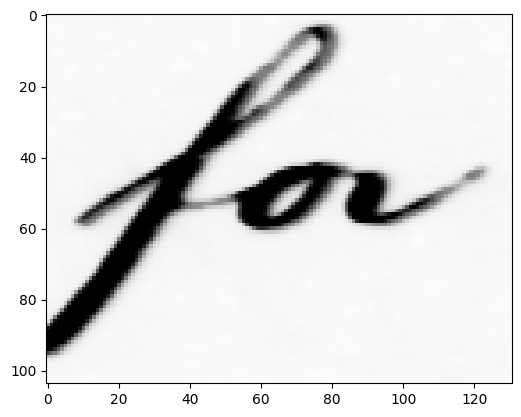

In [28]:
visual_word = visual_words[8]
x1, y1, x2, y2, desc = visual_word
document = Image.open(path_join('pages', '2700270.png'))
doc_arr = np.asarray(document, dtype='uint8')
req_arr = doc_arr[y1:y2, x1:x2]

print(doc_arr.shape, req_arr.shape)
plt.imshow(req_arr, cmap=cm.get_cmap("Greys_r"))

In [22]:
# compute features of full image
cell_size = 143 # req_arr.shape[1] # min(req_arr.shape) # use smaller dimension for patch (window) size
step_size = 20
doc_frames, doc_desc = compute_sift_descriptors(doc_arr)#, cell_size, step_size)
# print(len(doc_frames), len(doc_desc), cell_size)

In [24]:
# cluster and bin most significant features
n_centroids = 100
_, labels = kmeans2(doc_desc, n_centroids, iter=20, minit='points')

colormap = cm.get_cmap('jet')
bin_count = np.bincount(labels, minlength=n_centroids)
# plt.bar(list(range(n_centroids)), bin_count, color=[colormap(bin) for bin in bin_count])

[131 143 131 161 192 153 193 213 189 142 171 166 181 156 199 217 169 171
 136 158  85 160 144 172 144 243 172 183 156 109 155 130 136  90 263 151
 154 163 146 209 190 121 185 192 179 163 163 161 154 194 237 194 154 173
 211 188 277 157 175 173 185 154 141 174 159 298 151 203 174 137 173 146
 180 177 204 174 117 150 138 290 165 123 181 198 141 130 238 133 152 166
 167  97 168 201 161 134 150 200 207 117]


<BarContainer object of 100 artists>

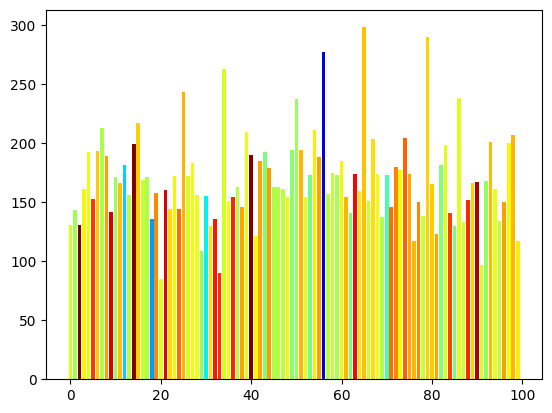

In [8]:
# compute sift descriptor for requested image
_, req_desc = compute_sift_descriptors(req_arr, cell_size=req_arr.shape[1], step_size=req_arr.shape[1])

if len(req_desc) != 1:
    raise Exception("Invalid computation of request image")

req_desc: np.ndarray = req_desc[0]

_, req_labels = kmeans2(doc_desc, n_centroids, iter=20, minit='points')

req_bin_count = np.bincount(req_labels, minlength=n_centroids)
print(req_bin_count)
plt.bar(list(range(n_centroids)), req_bin_count, color=[colormap(bin) for bin in bin_count])

In [9]:
def get_descriptor_labels_for_frame(frames, labels, coords):
    """1. look up all descriptors in a given frame (doc_frames, window_coords)
    2. get for each descriptor it's cluster and count the clusters for bag-of-features histogram (found_descriptors, labels)
    """
    y1, x1, y2, x2 = coords
    counted_labels = defaultdict(int)

    for idx, frame in enumerate(frames):
        if frame[0] < y1 or frame[0] > y2 or frame[1] < x1 or frame[1] > x2:
            continue
        else:
            counted_labels[labels[idx]] += 1

    return counted_labels

desc_clusters = get_descriptor_labels_for_frame(doc_frames, labels, visual_word[:4])
print(desc_clusters)

defaultdict(<class 'int'>, {59: 1, 57: 2, 82: 2, 64: 1, 27: 1, 4: 1, 31: 1, 72: 1, 8: 1, 94: 2, 88: 1, 25: 3, 93: 1, 78: 1, 36: 1, 9: 1, 91: 1, 61: 1, 5: 1, 24: 1, 55: 1, 62: 1, 63: 1, 50: 1, 37: 1, 67: 1, 20: 1, 51: 1, 81: 1, 21: 1, 2: 1})


In [10]:
def get_all_bag_of_features(doc_arr, frames, labels, step_size=20, cell_size=5):
    bafs = []
    for row in range(0, doc_arr.shape[0], step_size):
        for col in range(0, doc_arr.shape[1], step_size):
            y2 = row + cell_size
            x2 = col + cell_size

            if y2 <= doc_arr.shape[0] and x2 <= doc_arr.shape[1]:
                frame_baf = get_descriptor_labels_for_frame(frames, labels, (row, col, y2, x2))
                bafs.append({"window": (row, col, y2, x2), "baf": frame_baf})
            break
        break
    return bafs

bafs = get_all_bag_of_features(doc_arr, doc_frames, labels, step_size, cell_size)
bafs[0]

{'window': (0, 0, 143, 143),
 'baf': defaultdict(int,
             {37: 2,
              66: 1,
              48: 2,
              65: 1,
              69: 1,
              59: 1,
              22: 1,
              82: 1,
              99: 2,
              40: 4,
              20: 1,
              5: 1,
              61: 1,
              6: 2,
              51: 1,
              84: 1,
              24: 3,
              63: 1,
              56: 2,
              92: 4,
              11: 1,
              89: 2,
              75: 2,
              13: 2,
              14: 2,
              55: 1,
              10: 1,
              32: 1,
              95: 1,
              64: 1,
              80: 1,
              83: 1})}

In [11]:
def get_best_matching_descriptors(found_bafs, req_labels):
    results = []
    
    for entry in found_bafs:
        dist = 0

        y1, x1, _, _ = entry['window']
        if y1 != 2080:
            continue

        print(entry['baf'])

        for label, value in entry['baf'].items():
            print(f"{req_labels[label]=}, {value=}, {abs(req_labels[label] - value)=}")
            dist += abs(req_labels[label] - value)


        results.append((entry['window'], dist))
        
    return sorted(results, key=lambda x: x[-1])

best = get_best_matching_descriptors(bafs, req_labels)
best[:10]

[]

In [12]:
from matplotlib.patches import Circle, Rectangle
from matplotlib.lines import Line2D

def plot(im_arr, frames, n_centroids):
    draw_descriptor_cells = True
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(im_arr, cmap=cm.get_cmap('Greys_r'))
    ax.autoscale(enable=False)
    colormap = cm.get_cmap('jet')
    desc_len = cell_size * 4
    for (x, y), label in zip(frames, labels):
        color = colormap(label / float(n_centroids))
        circle = Circle((x, y), radius=1, fc=color, ec=color, alpha=1)
        rect = Rectangle((x - desc_len / 2, y - desc_len / 2), desc_len, desc_len, alpha=0.08, lw=1)
        ax.add_patch(circle)
        if draw_descriptor_cells:
            for p_factor in [0.25, 0.5, 0.75]:
                offset_dyn = desc_len * (0.5 - p_factor)
                offset_stat = desc_len * 0.5
                line_h = Line2D((x - offset_stat, x + offset_stat), (y - offset_dyn, y - offset_dyn), alpha=0.08, lw=1)
                line_v = Line2D((x - offset_dyn , x - offset_dyn), (y - offset_stat, y + offset_stat), alpha=0.08, lw=1)
                ax.add_line(line_h)
                ax.add_line(line_v)
        ax.add_patch(rect)

# plot(doc_arr, , len(visual_words))